##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
import tensorflow as tf



In [ ]:
df_daily = pd.read_csv("data_daily.csv")
df_daily

,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289
...,...,...
360,2021-12-27,10350408
361,2021-12-28,10219445
362,2021-12-29,10313337
363,2021-12-30,10310644


Let us plot daily receipt count. There seems to be a linear trend, but a lot of variability

<Axes: xlabel='# Date'>

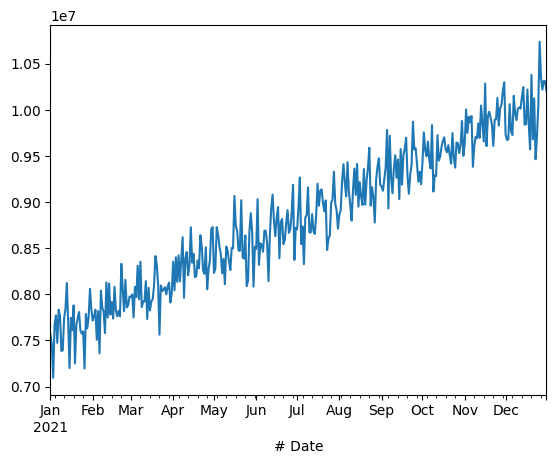

In [ ]:
df_daily["# Date"] = pd.to_datetime(df_daily["# Date"])
df_daily2 = df_daily.set_index("# Date")
df_daily2["Receipt_Count"].plot()

Since we are interested in the monthlies, let us plot that as well. this is a lot more regular (plotting the mean because months have different number of days). it seems that alpha*months(elapsed)*num_days in month is a good indicator of number of days. we will test this later with a simple linear model.

<Axes: xlabel='# Date'>

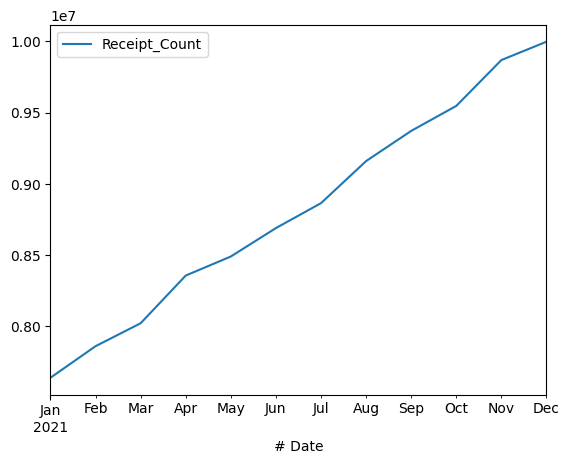

In [ ]:
df_daily2.groupby(pd.Grouper(freq='M')).mean().plot()

Week is also quite regular:

<Axes: xlabel='# Date'>

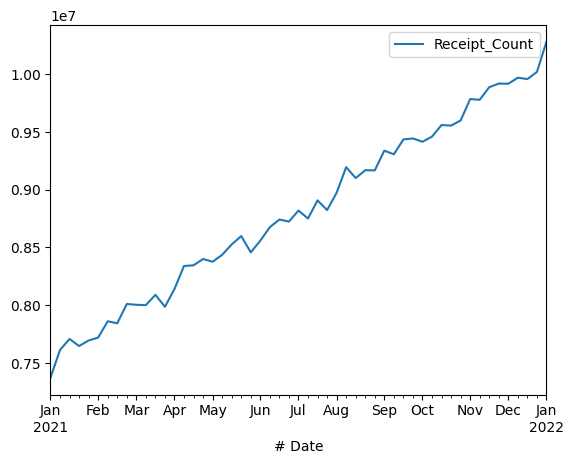

In [ ]:
df_daily2.groupby(pd.Grouper(freq='W')).mean().plot()

In [ ]:
df_daily_sorted = df_daily2.sort_index().copy()

In [ ]:
df_daily_sorted.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Receipt_Count,365.0,8.826566e+06,782008.894052,7095414.0,8142874.0,8799249.0,9476970.0,10738865.0


In [ ]:
df_daily_sorted["num_days_since_jan12021"]=((df_daily_sorted.index.to_series() - pd.to_datetime("2021-01-01"))).dt.days

In [ ]:
#df_daily_sorted["weekday"] = df_daily_sorted.index.to_series().dt.dayofweek

In [ ]:
mn = df_daily_sorted.mean()
dfstd =df_daily_sorted.std()
df_daily_sorted = (df_daily_sorted- mn)/dfstd
df_daily_sorted

,Receipt_Count,num_days_since_jan12021
# Date,,
2021-01-01,-1.613537,-1.724944
2021-01-02,-1.753231,-1.715466
2021-01-03,-2.213724,-1.705989
2021-01-04,-1.483874,-1.696511
2021-01-05,-1.349444,-1.687033
...,...,...
2021-12-27,1.948625,1.687033
2021-12-28,1.781155,1.696511
2021-12-29,1.901220,1.705989


In [ ]:
mn

Receipt_Count              8.826566e+06
num_days_since_jan12021    1.820000e+02
dtype: float64

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df_daily_sorted.columns)}
ndaily = len(df_daily_sorted)
train_df = df_daily_sorted[0:int(ndaily*0.7)]
val_df = df_daily_sorted[int(ndaily*0.7):int(ndaily*0.9)]
test_df = df_daily_sorted[int(ndaily*0.9):]

num_features = df_daily_sorted.shape[1]

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)
      # Slicing doesn't preserve static shape information, so set the shapes
      # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels


Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [ ]:
w1 = WindowGenerator(input_width=30, label_width=1, shift=30,
                     label_columns=['Receipt_Count'])
w1

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [59]
Label column name(s): ['Receipt_Count']

In [ ]:
w2 = WindowGenerator(input_width=30, label_width=1, shift=1,
                     label_columns=['Receipt_Count'])
w2

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Receipt_Count']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

Try it out:

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_window

<tf.Tensor: shape=(3, 31, 2), dtype=float64, numpy=
array([[[-1.6135367 , -1.72494414],
        [-1.75323077, -1.71546643],
        [-2.21372425, -1.70598871],
        [-1.48387449, -1.696511  ],
        [-1.3494438 , -1.68703328],
        [-1.73047399, -1.67755557],
        [-1.27101119, -1.66807785],
        [-1.3574501 , -1.65860014],
        [-1.84310059, -1.64912242],
        [-1.83435133, -1.63964471],
        [-1.39086276, -1.63016699],
        [-1.2605177 , -1.62068928],
        [-0.90027116, -1.61121156],
        [-1.44802835, -1.60173385],
        [-2.07922322, -1.59225613],
        [-1.3837388 , -1.58277842],
        [-1.55486474, -1.5733007 ],
        [-1.20926125, -1.56382299],
        [-2.01600527, -1.55434527],
        [-1.48357526, -1.54486756],
        [-1.38628737, -1.53538984],
        [-1.30321798, -1.52591213],
        [-1.56384545, -1.51643441],
        [-1.60307518, -1.5069567 ],
        [-1.57084281, -1.49747898],
        [-2.08677812, -1.48800127],
        [-1.

In [ ]:
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 31, 2)
Inputs shape: (3, 30, 2)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='Receipt_Count', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

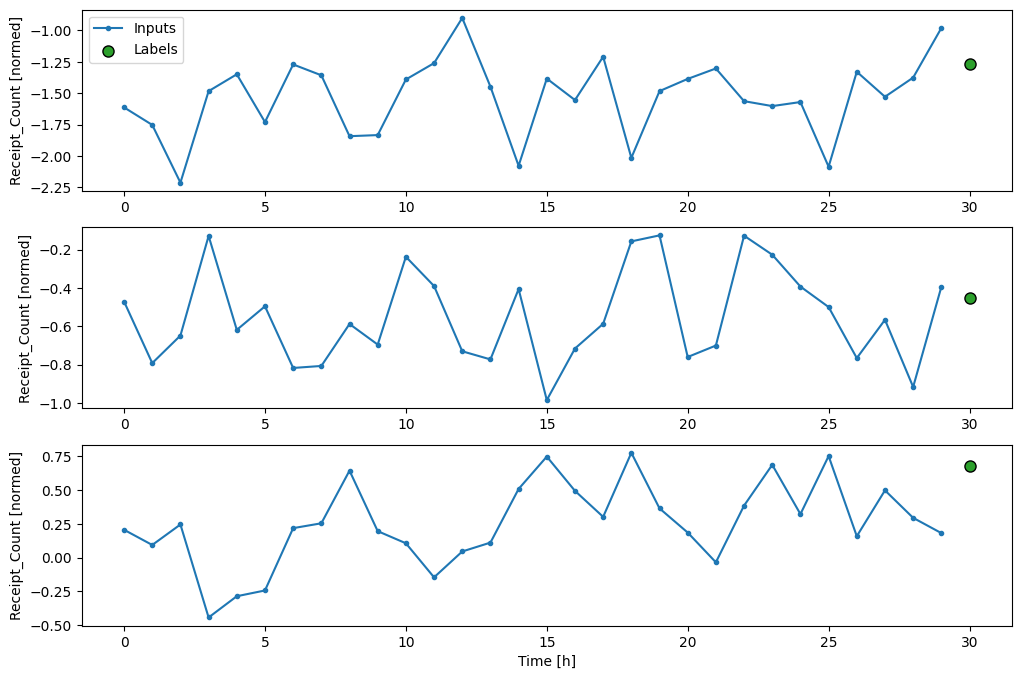

In [ ]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 30, 2), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 2)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Receipt_Count'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Receipt_Count']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 2)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature.

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [ ]:
baseline = Baseline(label_index=column_indices['Receipt_Count'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 10ms/step - loss: 0.1198 - mean_absolute_error: 0.2739


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [ ]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=['Receipt_Count'])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Receipt_Count']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 30, 2)
Output shape: (32, 30, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

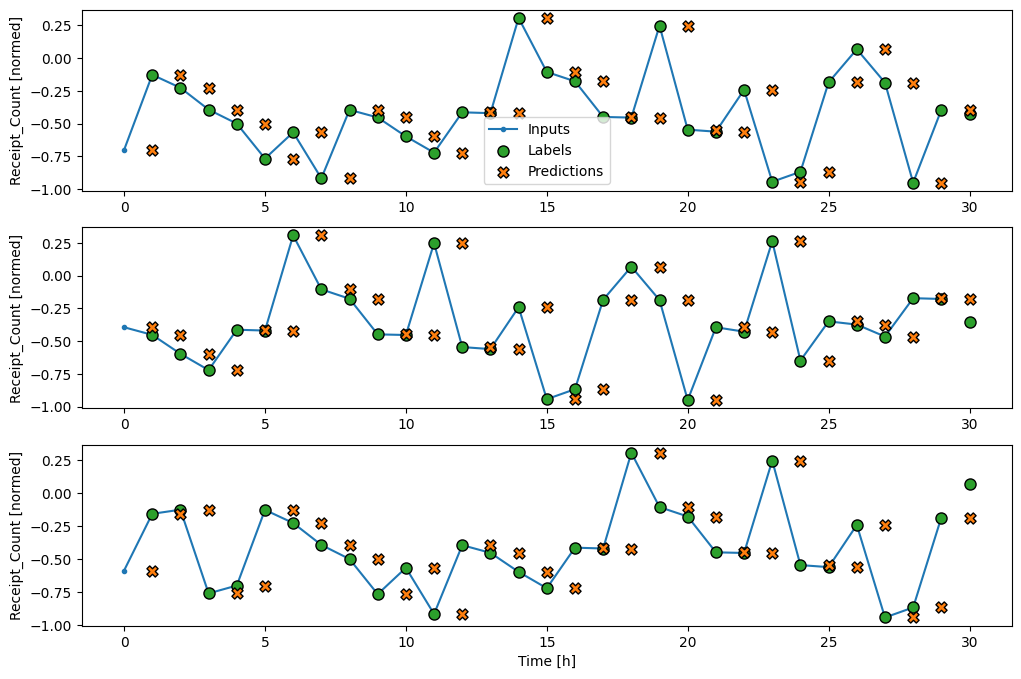

In [ ]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 2)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [ ]:
MAX_EPOCHS = 1200

def compile_and_fit(model, window, patience=16):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Train the model and evaluate its performance:

In [ ]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/1200
8/8 [==============================] - 3s 72ms/step - loss: 4.6655 - mean_absolute_error: 1.7766 - val_loss: 6.7144 - val_mean_absolute_error: 2.5140
Epoch 2/1200
8/8 [==============================] - 0s 20ms/step - loss: 4.5883 - mean_absolute_error: 1.7616 - val_loss: 6.6698 - val_mean_absolute_error: 2.5060
Epoch 3/1200
8/8 [==============================] - 0s 25ms/step - loss: 4.5120 - mean_absolute_error: 1.7470 - val_loss: 6.6261 - val_mean_absolute_error: 2.4981
Epoch 4/1200
8/8 [==============================] - 0s 35ms/step - loss: 4.4358 - mean_absolute_error: 1.7323 - val_loss: 6.5819 - val_mean_absolute_error: 2.4901
Epoch 5/1200
8/8 [==============================] - 0s 21ms/step - loss: 4.3611 - mean_absolute_error: 1.7178 - val_loss: 6.5379 - val_mean_absolute_error: 2.4820
Epoch 6/1200
8/8 [==============================] - 0s 37ms/step - loss: 4.2867 - mean_absolute_error: 1.7031 - val_loss: 6.4948 - val_mean_absolute_error: 2.4741
Epoch 7/1200
8/8 [====

Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 30, 2)
Output shape: (32, 30, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input temperature, but in a few cases it's worse:

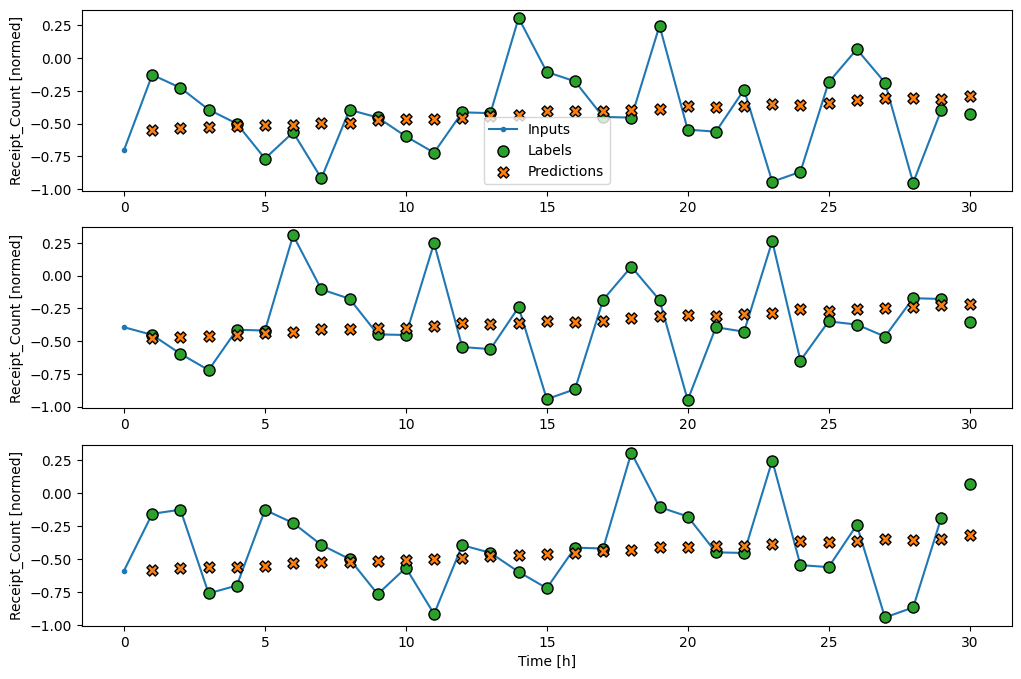

In [ ]:
wide_window.plot(linear)

One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

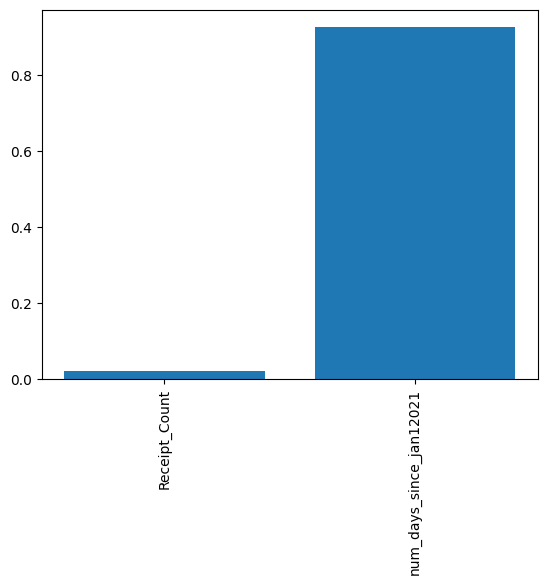

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Sometimes the model doesn't even place the most weight on the input `T (degC)`. This is one of the risks of random initialization.

### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output:

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=4, activation='relu',kernel_regularizer = tf.keras.regularizers.L1(0.2)),
    tf.keras.layers.Dense(units=4, activation='relu',kernel_regularizer = tf.keras.regularizers.L1(0.3)),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window,patience=15)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/1200
8/8 [==============================] - 1s 40ms/step - loss: 3.7847 - mean_absolute_error: 0.7865 - val_loss: 3.3409 - val_mean_absolute_error: 0.6862
Epoch 2/1200
8/8 [==============================] - 0s 9ms/step - loss: 3.6799 - mean_absolute_error: 0.7614 - val_loss: 3.3253 - val_mean_absolute_error: 0.7044
Epoch 3/1200
8/8 [==============================] - 0s 14ms/step - loss: 3.5854 - mean_absolute_error: 0.7416 - val_loss: 3.3049 - val_mean_absolute_error: 0.7201
Epoch 4/1200
8/8 [==============================] - 0s 8ms/step - loss: 3.5038 - mean_absolute_error: 0.7274 - val_loss: 3.2806 - val_mean_absolute_error: 0.7338
Epoch 5/1200
8/8 [==============================] - 0s 12ms/step - loss: 3.4331 - mean_absolute_error: 0.7168 - val_loss: 3.2528 - val_mean_absolute_error: 0.7453
Epoch 6/1200
8/8 [==============================] - 0s 14ms/step - loss: 3.3647 - mean_absolute_error: 0.7079 - val_loss: 3.2246 - val_mean_absolute_error: 0.7567
Epoch 7/1200
8/8 [======

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [ ]:
CONV_WIDTH = 5
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Receipt_Count'])

conv_window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['Receipt_Count']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

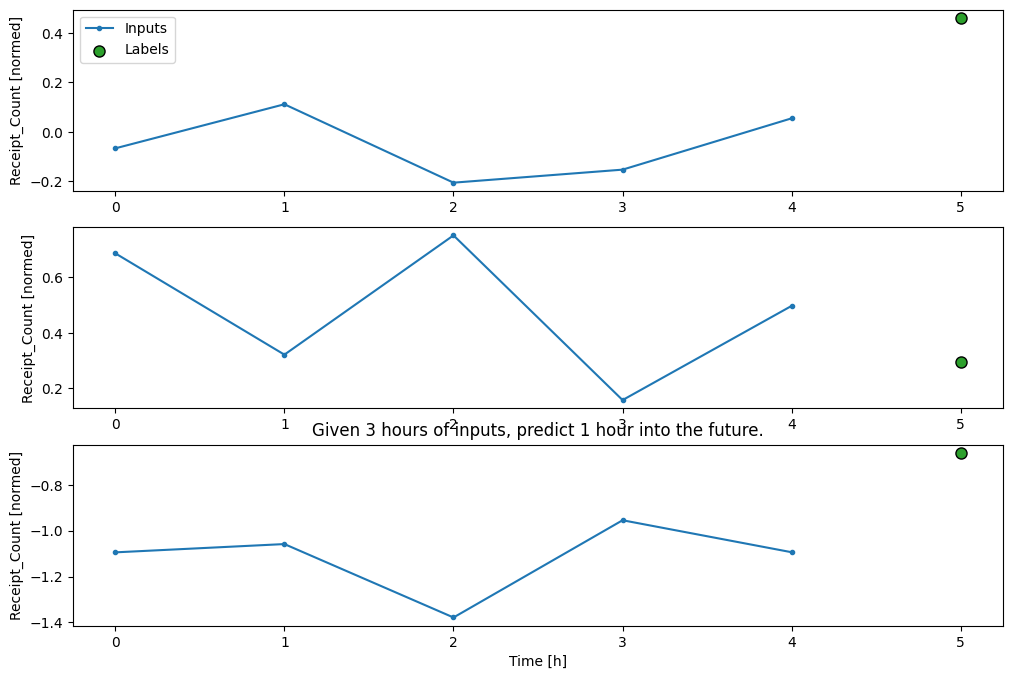

In [ ]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu',kernel_regularizer = tf.keras.regularizers.L1(0.0002)),
    tf.keras.layers.Dense(units=16, activation='relu',kernel_regularizer = tf.keras.regularizers.L1(0.00002)),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 5, 2)
Output shape: (32, 1, 1)


In [ ]:
history = compile_and_fit(multi_step_dense, conv_window,patience=16)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/1200
8/8 [==============================] - 1s 34ms/step - loss: 1.1841 - mean_absolute_error: 0.8747 - val_loss: 1.1630 - val_mean_absolute_error: 1.0265
Epoch 2/1200
8/8 [==============================] - 0s 9ms/step - loss: 0.8810 - mean_absolute_error: 0.7561 - val_loss: 1.0420 - val_mean_absolute_error: 0.9689
Epoch 3/1200
8/8 [==============================] - 0s 9ms/step - loss: 0.6168 - mean_absolute_error: 0.6327 - val_loss: 0.9426 - val_mean_absolute_error: 0.9179
Epoch 4/1200
8/8 [==============================] - 0s 14ms/step - loss: 0.3860 - mean_absolute_error: 0.5019 - val_loss: 0.8366 - val_mean_absolute_error: 0.8595
Epoch 5/1200
8/8 [==============================] - 0s 14ms/step - loss: 0.2292 - mean_absolute_error: 0.3838 - val_loss: 0.7040 - val_mean_absolute_error: 0.7813
Epoch 6/1200
8/8 [==============================] - 0s 14ms/step - loss: 0.1481 - mean_absolute_error: 0.2986 - val_loss: 0.5425 - val_mean_absolute_error: 0.6737
Epoch 7/1200
8/8 [======

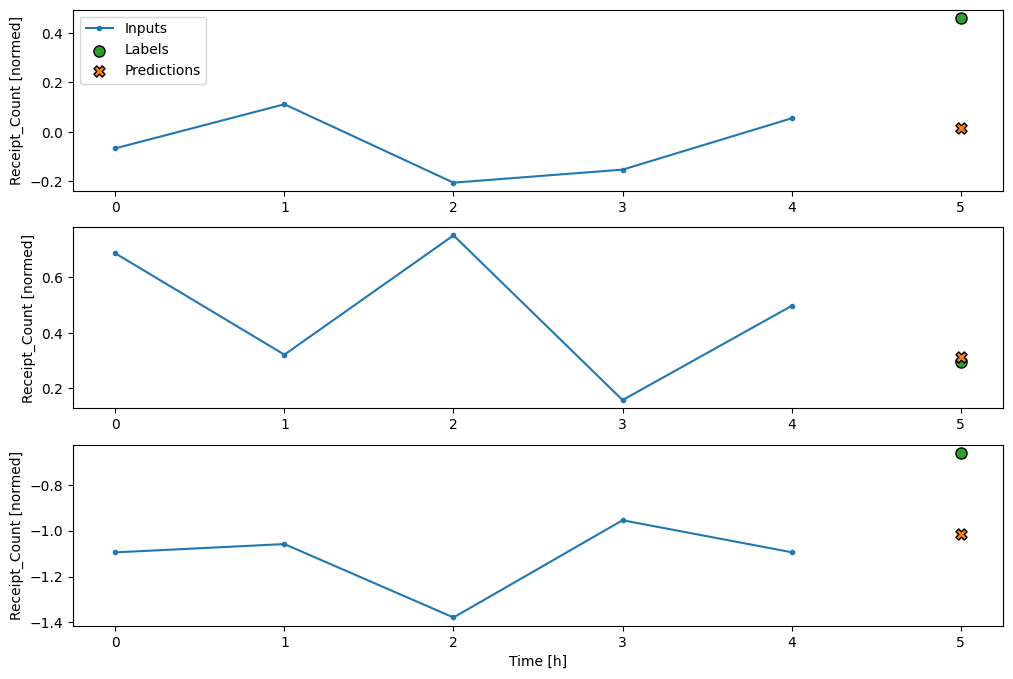

In [ ]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 30, 2)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 10, but received input with shape (32, 60)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 30, 2), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

### Convolution neural network

A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution.

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=30,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=30, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 5, 2)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [ ]:
history = compile_and_fit(conv_model, conv_window,patience=16)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/1200
8/8 [==============================] - 1s 32ms/step - loss: 0.5166 - mean_absolute_error: 0.5973 - val_loss: 1.4076 - val_mean_absolute_error: 1.1418
Epoch 2/1200
8/8 [==============================] - 0s 14ms/step - loss: 0.2193 - mean_absolute_error: 0.3812 - val_loss: 1.0353 - val_mean_absolute_error: 0.9704
Epoch 3/1200
8/8 [==============================] - 0s 9ms/step - loss: 0.1201 - mean_absolute_error: 0.2704 - val_loss: 0.5871 - val_mean_absolute_error: 0.7090
Epoch 4/1200
8/8 [==============================] - 0s 14ms/step - loss: 0.1110 - mean_absolute_error: 0.2602 - val_loss: 0.2185 - val_mean_absolute_error: 0.4010
Epoch 5/1200
8/8 [==============================] - 0s 13ms/step - loss: 0.0912 - mean_absolute_error: 0.2396 - val_loss: 0.0893 - val_mean_absolute_error: 0.2450
Epoch 6/1200
8/8 [==============================] - 0s 8ms/step - loss: 0.0891 - mean_absolute_error: 0.2375 - val_loss: 0.0724 - val_mean_absolute_error: 0.2205
Epoch 7/1200
8/8 [======

The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

If you run it on wider input, it produces wider output:

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 30, 2)
Labels shape: (32, 30, 1)
Output shape: (32, 26, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match:

In [ ]:
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Receipt_Count'])

wide_conv_window

Total window size: 35
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Label indices: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34]
Label column name(s): ['Receipt_Count']

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 34, 2)
Labels shape: (32, 30, 1)
Output shape: (32, 30, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

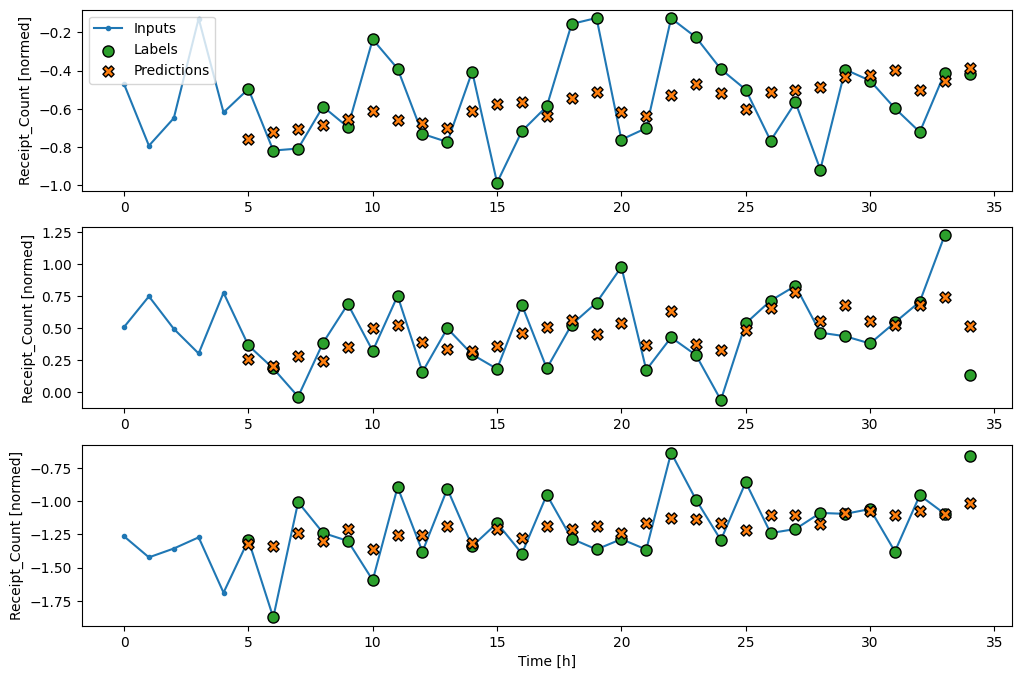

In [ ]:
wide_conv_window.plot(conv_model)

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers.
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(28, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 2)
Output shape: (32, 30, 1)


In [ ]:
history = compile_and_fit(lstm_model, wide_window,patience=16)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/1200
8/8 [==============================] - 3s 100ms/step - loss: 0.7077 - mean_absolute_error: 0.6895 - val_loss: 1.0161 - val_mean_absolute_error: 0.9726
Epoch 2/1200
8/8 [==============================] - 0s 24ms/step - loss: 0.4140 - mean_absolute_error: 0.5229 - val_loss: 0.7750 - val_mean_absolute_error: 0.8420
Epoch 3/1200
8/8 [==============================] - 0s 23ms/step - loss: 0.2407 - mean_absolute_error: 0.3887 - val_loss: 0.5893 - val_mean_absolute_error: 0.7232
Epoch 4/1200
8/8 [==============================] - 0s 23ms/step - loss: 0.1839 - mean_absolute_error: 0.3326 - val_loss: 0.4696 - val_mean_absolute_error: 0.6340
Epoch 5/1200
8/8 [==============================] - 0s 19ms/step - loss: 0.1772 - mean_absolute_error: 0.3281 - val_loss: 0.3998 - val_mean_absolute_error: 0.5766
Epoch 6/1200
8/8 [==============================] - 0s 20ms/step - loss: 0.1574 - mean_absolute_error: 0.3023 - val_loss: 0.3677 - val_mean_absolute_error: 0.5486
Epoch 7/1200
8/8 [===

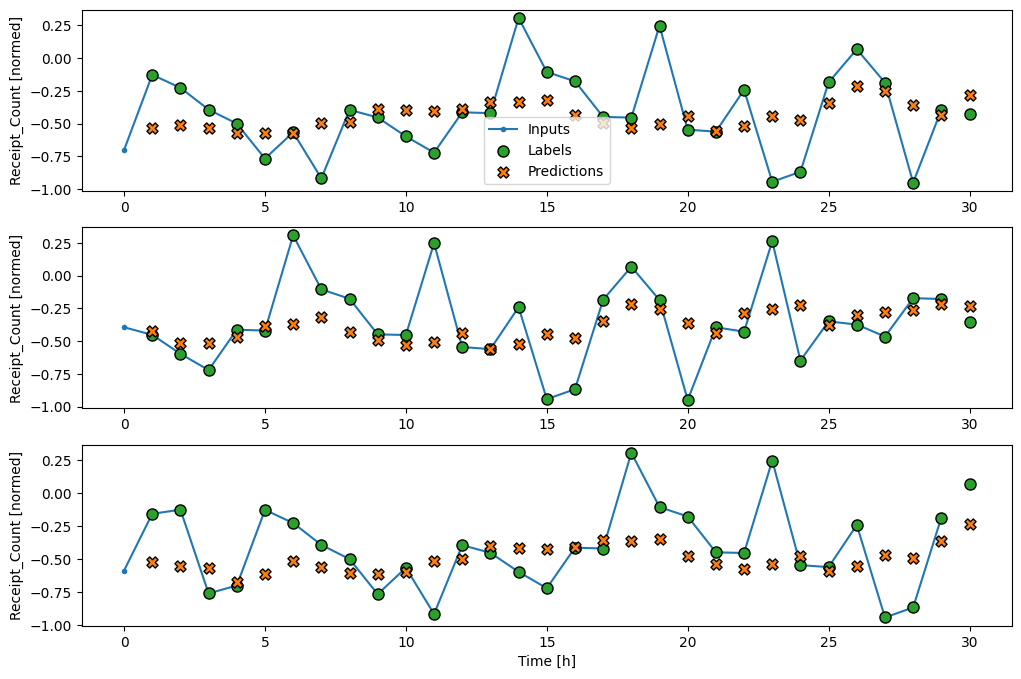

In [ ]:
wide_window.plot(lstm_model)


### Performance

With this dataset typically each of the models does slightly better than the one before it:

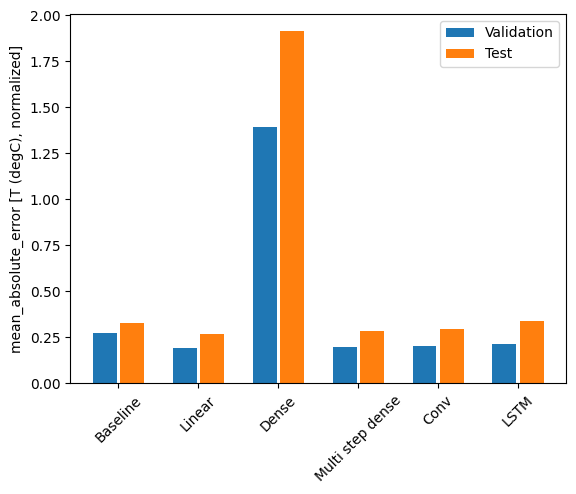

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.3277
Linear      : 0.2709
Dense       : 1.9131
Multi step dense: 0.2829
Conv        : 0.2971
LSTM        : 0.3386


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/residual.png?raw=1)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial.

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm2 = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(26, return_sequences=True),
    tf.keras.layers.Dense(
        1,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm2, wide_window, patience=20)

val_performance['Residual LSTM'] = residual_lstm2.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm2.evaluate(wide_window.test, verbose=0)


Epoch 1/1200
8/8 [==============================] - 4s 135ms/step - loss: 0.1121 - mean_absolute_error: 0.2629 - val_loss: 0.0783 - val_mean_absolute_error: 0.2187
Epoch 2/1200
8/8 [==============================] - 0s 36ms/step - loss: 0.1114 - mean_absolute_error: 0.2625 - val_loss: 0.0783 - val_mean_absolute_error: 0.2180
Epoch 3/1200
8/8 [==============================] - 0s 23ms/step - loss: 0.1110 - mean_absolute_error: 0.2620 - val_loss: 0.0782 - val_mean_absolute_error: 0.2178
Epoch 4/1200
8/8 [==============================] - 0s 19ms/step - loss: 0.1106 - mean_absolute_error: 0.2614 - val_loss: 0.0784 - val_mean_absolute_error: 0.2175
Epoch 5/1200
8/8 [==============================] - 0s 25ms/step - loss: 0.1102 - mean_absolute_error: 0.2609 - val_loss: 0.0786 - val_mean_absolute_error: 0.2175
Epoch 6/1200
8/8 [==============================] - 0s 18ms/step - loss: 0.1097 - mean_absolute_error: 0.2603 - val_loss: 0.0788 - val_mean_absolute_error: 0.2174
Epoch 7/1200
8/8 [===

In [ ]:
residual_lstm2.summary()

Model: "residual_wrapper"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 30, 1)             3043      
                                                                 
Total params: 3043 (11.89 KB)
Trainable params: 3043 (11.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
print('Output shape:', residual_lstm2(wide_window.example[0]).shape)

Output shape: (32, 30, 2)


In [ ]:
wide_window.example[0]

<tf.Tensor: shape=(32, 30, 2), dtype=float32, numpy=
array([[[-0.7008003 , -0.5781406 ],
        [-0.12665336, -0.5686629 ],
        [-0.22615606, -0.5591852 ],
        ...,
        [-0.18678182, -0.32224232],
        [-0.95036525, -0.31276459],
        [-0.39459404, -0.30328688]],

       [[-0.39439327, -0.5023189 ],
        [-0.4525857 , -0.49284118],
        [-0.59716207, -0.48336348],
        ...,
        [-0.4654449 , -0.24642059],
        [-0.1724623 , -0.23694287],
        [-0.17851722, -0.22746517]],

       [[-0.5871136 , -0.6160515 ],
        [-0.15641516, -0.60657376],
        [-0.12499864, -0.597096  ],
        ...,
        [-0.94344586, -0.36015317],
        [-0.86737   , -0.35067546],
        [-0.1844302 , -0.34119773]],

       ...,

       [[-0.22048604,  0.11373258],
        [ 0.0438447 ,  0.1232103 ],
        [ 0.4755981 ,  0.13268802],
        ...,
        [-0.03493189,  0.36963087],
        [ 0.38423085,  0.3791086 ],
        [ 0.6858924 ,  0.3885863 ]],

       [[-

#### Performance

Here is the overall performance for these multi-output models.

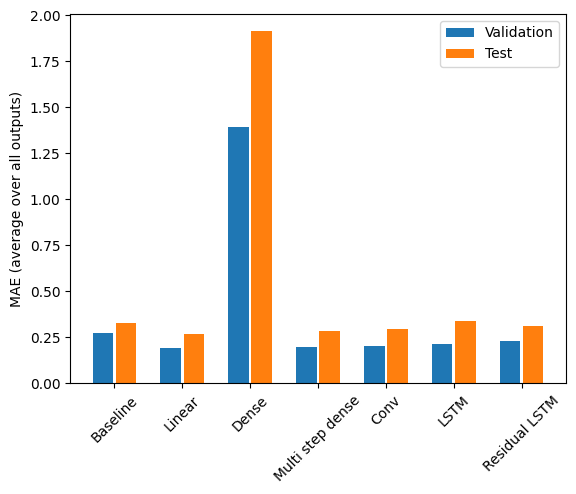

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.3277
Linear         : 0.2709
Dense          : 1.9131
Multi step dense: 0.2829
Conv           : 0.2971
LSTM           : 0.3386
Residual LSTM  : 0.3103


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 36
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35]
Label column name(s): None

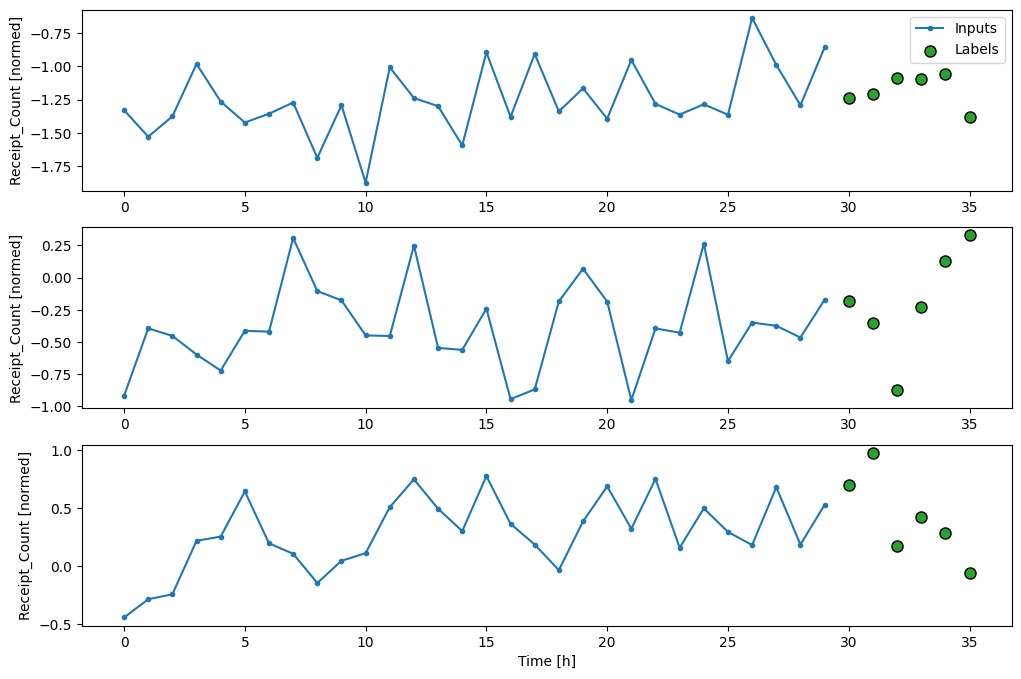

In [ ]:
OUT_STEPS = 6
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_last.png?raw=1)

1/1 [==============================] - 0s 49ms/step - loss: 0.2312 - mean_absolute_error: 0.3162


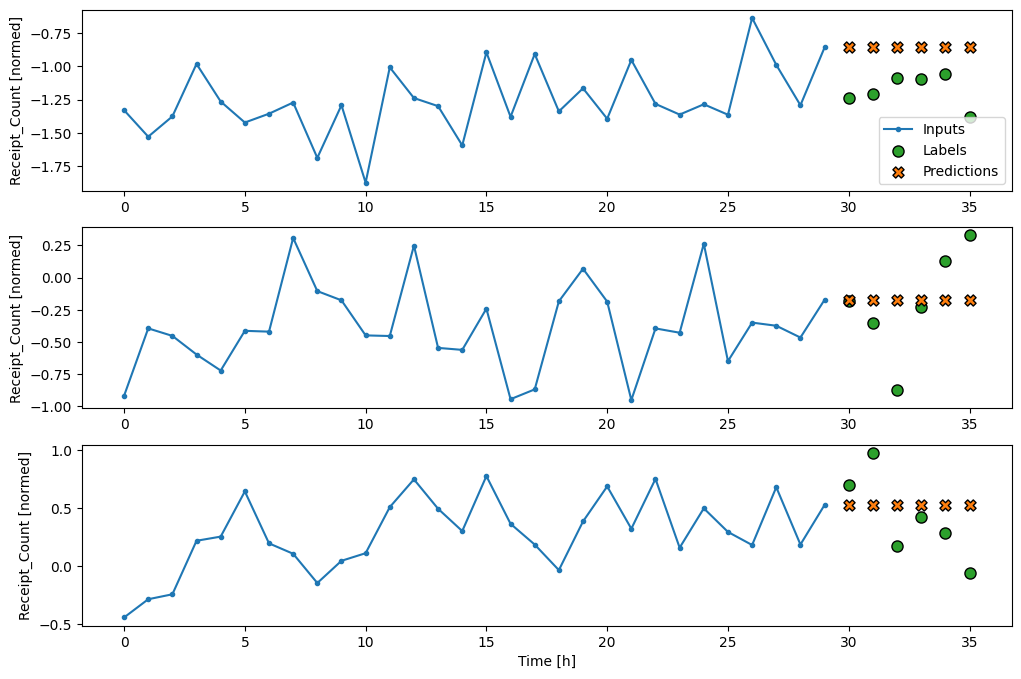

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test)

multi_window.plot(last_baseline)

In [ ]:
multi_performance

{'Last': [0.23122940957546234, 0.3162393867969513]}

In [ ]:
multi_val_performance

{'Last': [0.05024449899792671, 0.14219826459884644]}

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_repeat.png?raw=1)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

Epoch 1/1200
7/7 [==============================] - 1s 37ms/step - loss: 0.5116 - mean_absolute_error: 0.5924 - val_loss: 1.3517 - val_mean_absolute_error: 1.1460
Epoch 2/1200
7/7 [==============================] - 0s 8ms/step - loss: 0.4936 - mean_absolute_error: 0.5824 - val_loss: 1.3314 - val_mean_absolute_error: 1.1373
Epoch 3/1200
7/7 [==============================] - 0s 16ms/step - loss: 0.4761 - mean_absolute_error: 0.5723 - val_loss: 1.3116 - val_mean_absolute_error: 1.1287
Epoch 4/1200
7/7 [==============================] - 0s 16ms/step - loss: 0.4588 - mean_absolute_error: 0.5623 - val_loss: 1.2921 - val_mean_absolute_error: 1.1201
Epoch 5/1200
7/7 [==============================] - 0s 9ms/step - loss: 0.4424 - mean_absolute_error: 0.5524 - val_loss: 1.2727 - val_mean_absolute_error: 1.1116
Epoch 6/1200
7/7 [==============================] - 0s 10ms/step - loss: 0.4269 - mean_absolute_error: 0.5429 - val_loss: 1.2533 - val_mean_absolute_error: 1.1030
Epoch 7/1200
7/7 [======

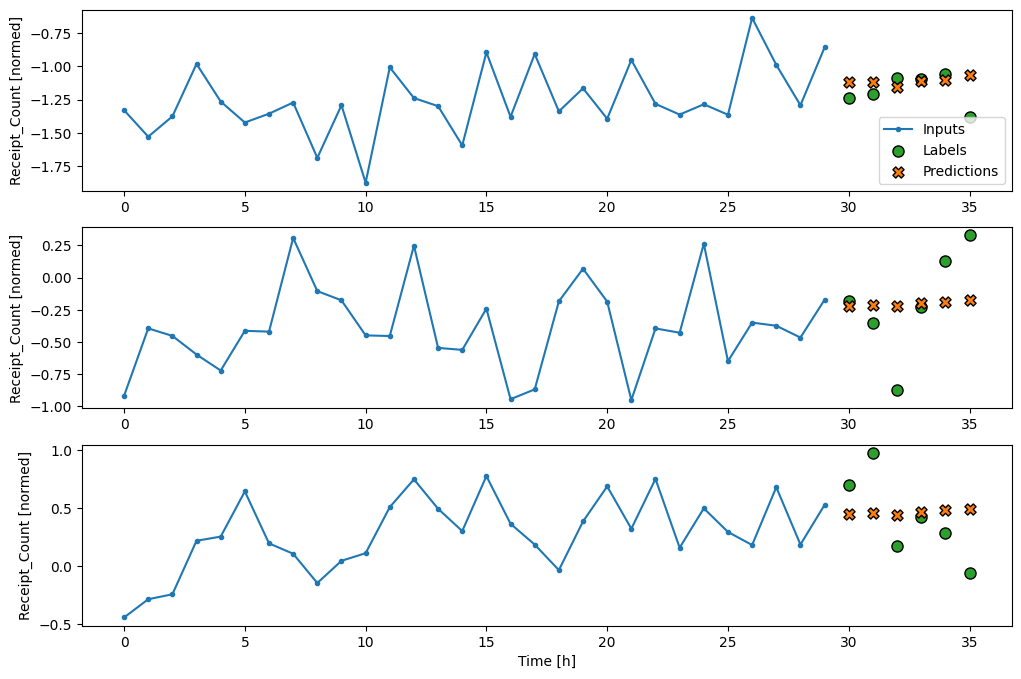

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

Epoch 1/1200
7/7 [==============================] - 1s 33ms/step - loss: 0.4623 - mean_absolute_error: 0.5624 - val_loss: 1.0502 - val_mean_absolute_error: 1.0073
Epoch 2/1200
7/7 [==============================] - 0s 17ms/step - loss: 0.3067 - mean_absolute_error: 0.4570 - val_loss: 0.6676 - val_mean_absolute_error: 0.7969
Epoch 3/1200
7/7 [==============================] - 0s 9ms/step - loss: 0.1558 - mean_absolute_error: 0.3194 - val_loss: 0.3093 - val_mean_absolute_error: 0.5279
Epoch 4/1200
7/7 [==============================] - 0s 9ms/step - loss: 0.0675 - mean_absolute_error: 0.1993 - val_loss: 0.0889 - val_mean_absolute_error: 0.2547
Epoch 5/1200
7/7 [==============================] - 0s 11ms/step - loss: 0.0673 - mean_absolute_error: 0.1953 - val_loss: 0.0346 - val_mean_absolute_error: 0.1310
Epoch 6/1200
7/7 [==============================] - 0s 10ms/step - loss: 0.0630 - mean_absolute_error: 0.1906 - val_loss: 0.0367 - val_mean_absolute_error: 0.1350
Epoch 7/1200
7/7 [======

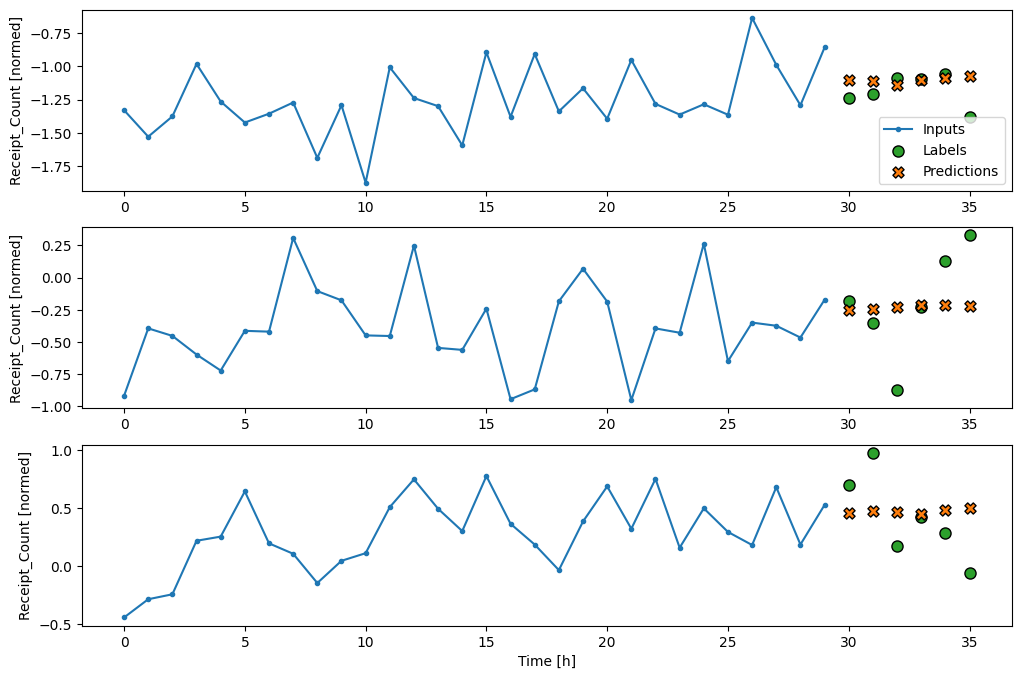

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

Epoch 1/1200
7/7 [==============================] - 1s 33ms/step - loss: 2.0057 - mean_absolute_error: 0.5935 - val_loss: 2.8265 - val_mean_absolute_error: 1.1466
Epoch 2/1200
7/7 [==============================] - 0s 9ms/step - loss: 1.9613 - mean_absolute_error: 0.5863 - val_loss: 2.7774 - val_mean_absolute_error: 1.1388
Epoch 3/1200
7/7 [==============================] - 0s 8ms/step - loss: 1.9167 - mean_absolute_error: 0.5785 - val_loss: 2.7295 - val_mean_absolute_error: 1.1314
Epoch 4/1200
7/7 [==============================] - 0s 9ms/step - loss: 1.8741 - mean_absolute_error: 0.5712 - val_loss: 2.6844 - val_mean_absolute_error: 1.1245
Epoch 5/1200
7/7 [==============================] - 0s 9ms/step - loss: 1.8325 - mean_absolute_error: 0.5638 - val_loss: 2.6402 - val_mean_absolute_error: 1.1181
Epoch 6/1200
7/7 [==============================] - 0s 15ms/step - loss: 1.7909 - mean_absolute_error: 0.5565 - val_loss: 2.5978 - val_mean_absolute_error: 1.1124
Epoch 7/1200
7/7 [========

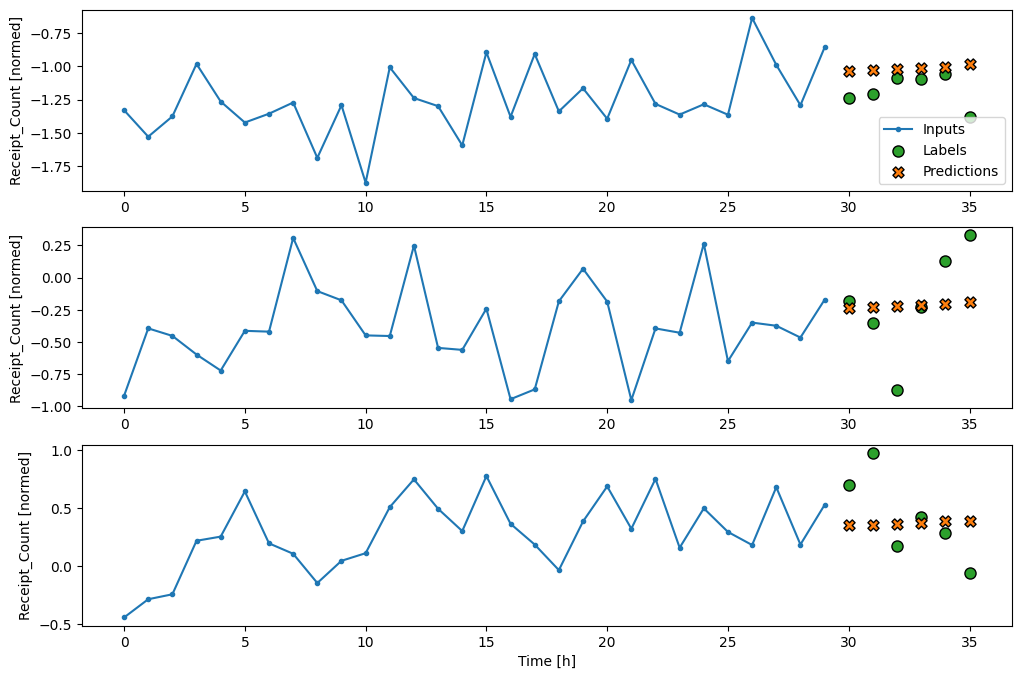

In [ ]:
CONV_WIDTH = 4
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(3, activation='relu', kernel_size=(CONV_WIDTH),kernel_regularizer = tf.keras.regularizers.L1(0.2)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window,patience=16)


multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


Epoch 1/1200
7/7 [==============================] - 3s 99ms/step - loss: 0.5073 - mean_absolute_error: 0.5900 - val_loss: 1.3224 - val_mean_absolute_error: 1.1332
Epoch 2/1200
7/7 [==============================] - 0s 25ms/step - loss: 0.4701 - mean_absolute_error: 0.5678 - val_loss: 1.2626 - val_mean_absolute_error: 1.1067
Epoch 3/1200
7/7 [==============================] - 0s 20ms/step - loss: 0.4135 - mean_absolute_error: 0.5296 - val_loss: 1.1940 - val_mean_absolute_error: 1.0754
Epoch 4/1200
7/7 [==============================] - 0s 26ms/step - loss: 0.3343 - mean_absolute_error: 0.4752 - val_loss: 1.1202 - val_mean_absolute_error: 1.0405
Epoch 5/1200
7/7 [==============================] - 0s 27ms/step - loss: 0.2571 - mean_absolute_error: 0.4196 - val_loss: 1.0488 - val_mean_absolute_error: 1.0056
Epoch 6/1200
7/7 [==============================] - 0s 18ms/step - loss: 0.1988 - mean_absolute_error: 0.3731 - val_loss: 0.9913 - val_mean_absolute_error: 0.9766
Epoch 7/1200
7/7 [====

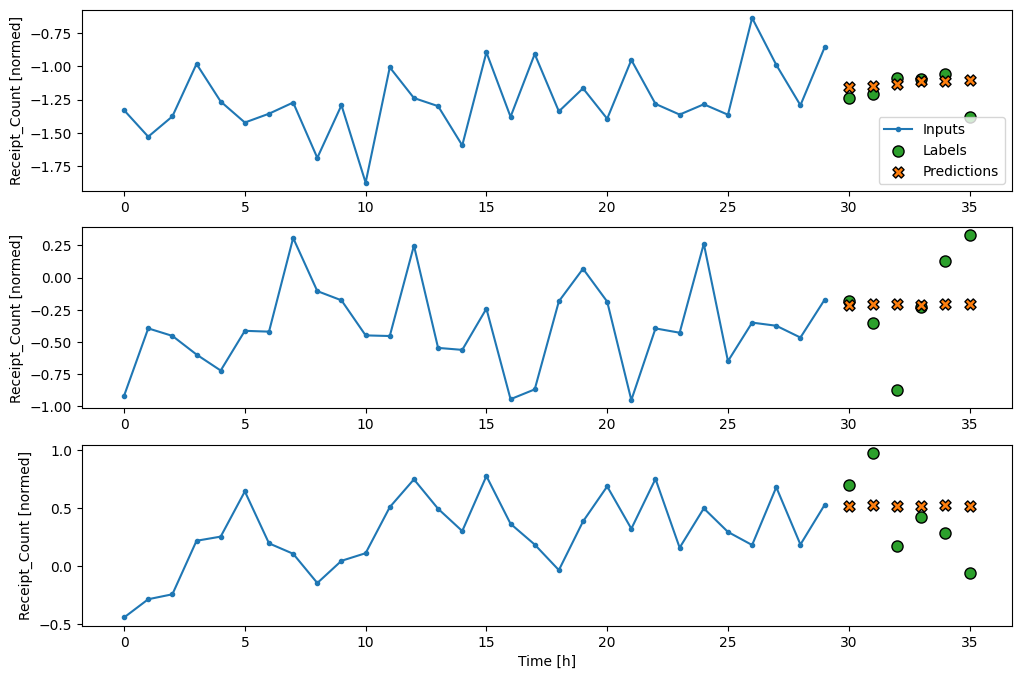

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(20, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)


multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_autoregressive.png?raw=1)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=20, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 2])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 6, 2)


Now, train the model:

Epoch 1/1200
7/7 [==============================] - 3s 108ms/step - loss: 0.5690 - mean_absolute_error: 0.6244 - val_loss: 1.5594 - val_mean_absolute_error: 1.2305
Epoch 2/1200
7/7 [==============================] - 0s 35ms/step - loss: 0.4356 - mean_absolute_error: 0.5459 - val_loss: 1.4060 - val_mean_absolute_error: 1.1662
Epoch 3/1200
7/7 [==============================] - 0s 38ms/step - loss: 0.3362 - mean_absolute_error: 0.4735 - val_loss: 1.2606 - val_mean_absolute_error: 1.1012
Epoch 4/1200
7/7 [==============================] - 0s 38ms/step - loss: 0.2387 - mean_absolute_error: 0.3982 - val_loss: 1.1265 - val_mean_absolute_error: 1.0382
Epoch 5/1200
7/7 [==============================] - 0s 36ms/step - loss: 0.1653 - mean_absolute_error: 0.3348 - val_loss: 0.9987 - val_mean_absolute_error: 0.9749
Epoch 6/1200
7/7 [==============================] - 0s 35ms/step - loss: 0.1143 - mean_absolute_error: 0.2792 - val_loss: 0.8880 - val_mean_absolute_error: 0.9169
Epoch 7/1200
7/7 [===

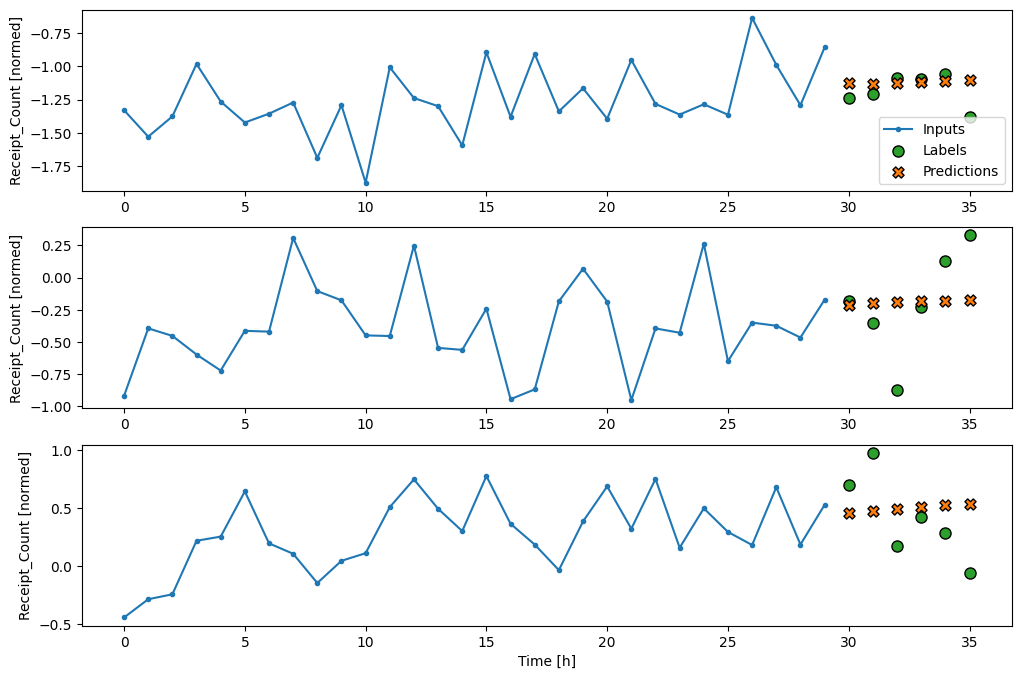

In [ ]:
history = compile_and_fit(feedback_model, multi_window)


multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

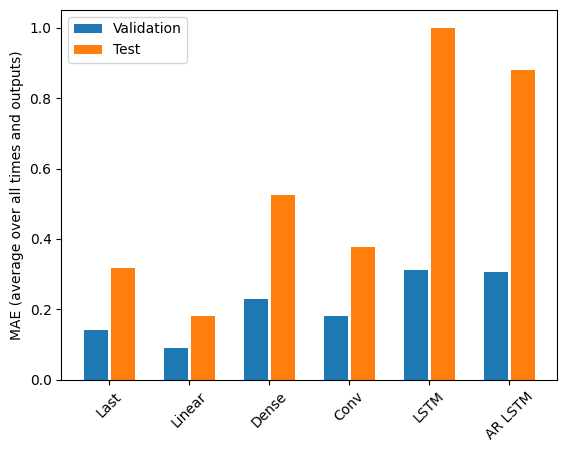

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [ ]:
lstm_model.metrics_names

['loss', 'mean_absolute_error']

In [ ]:
multi_performance.values()

dict_values([[0.23122940957546234, 0.3162393867969513], [0.09576033800840378, 0.1813534051179886], [0.3294239342212677, 0.5253215432167053], [0.27356263995170593, 0.3759783208370209], [1.0474919080734253, 1.0008550882339478], [0.8112514615058899, 0.8807026743888855]])

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps.

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.3162
Linear  : 0.1814
Dense   : 0.5253
Conv    : 0.3760
LSTM    : 1.0009
AR LSTM : 0.8807


In [ ]:
multi_linear_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 1, 2)              0         
                                                                 
 dense_11 (Dense)            (None, 1, 12)             36        
                                                                 
 reshape_1 (Reshape)         (None, 6, 2)              0         
                                                                 
Total params: 36 (144.00 Byte)
Trainable params: 36 (144.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
multi_linear_model(tf.constant([[[0.1,0.2] for x in range(7)]]))
multi_linear_model.save("/content/drive/MyDrive/multimodelfile2",save_format="tf")

The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.